<a href="https://colab.research.google.com/github/InKyuHwang001/Kaggle/blob/master/PFS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import time
import itertools
import gc
import pickle
from xgboost import XGBRegressor
from xgboost import plot_importance

%matplotlib inline

# Load Data

In [2]:
df_train = pd.read_csv('/content/drive/MyDrive/data/kaggle/competitive-data-science-predict-future-sales/sales_train.csv')
df_test = pd.read_csv('/content/drive/MyDrive/data/kaggle/competitive-data-science-predict-future-sales/test.csv')
df_items = pd.read_csv('/content/drive/MyDrive/data/kaggle/competitive-data-science-predict-future-sales/items.csv')
df_item_categories = pd.read_csv('/content/drive/MyDrive/data/kaggle/competitive-data-science-predict-future-sales/item_categories.csv')
df_shops = pd.read_csv('/content/drive/MyDrive/data/kaggle/competitive-data-science-predict-future-sales/shops.csv')

In [3]:
df_train.head(2)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0


In [4]:
df_train.tail(2)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2935847,22.10.2015,33,25,7440,299.0,1.0
2935848,03.10.2015,33,25,7460,299.0,1.0


In [5]:
df_test.head(3)

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233


In [6]:
df_items.head(3)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40


In [7]:
df_shops.head(3)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


# Preliminary Wrangling


## 중복 체크


In [9]:
sum(df_train.duplicated()), sum(df_test.duplicated())

(6, 0)

In [10]:
sum(df_items.duplicated()), sum(df_item_categories.duplicated()), sum(df_shops.duplicated())

(0, 0, 0)

df_train에만 중복 행이 6개 있음

In [11]:
df_train[df_train.duplicated() == True]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
76962,05.01.2013,0,54,20130,149.0,1.0
1435367,23.02.2014,13,50,3423,999.0,1.0
1496766,23.03.2014,14,21,3423,999.0,1.0
1671873,01.05.2014,16,50,3423,999.0,1.0
1866340,12.07.2014,18,25,3423,999.0,1.0
2198566,31.12.2014,23,42,21619,499.0,1.0


In [12]:
# 중복 제거
df_train.drop_duplicates(inplace=True)

# 중복 재확인
sum(df_train.duplicated())

0

## Null 

In [13]:
df_train.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [14]:
df_test.isnull().sum()

ID         0
shop_id    0
item_id    0
dtype: int64

## Outlier 제거

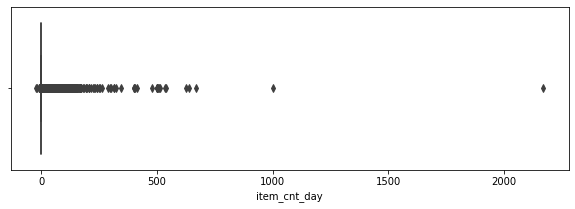

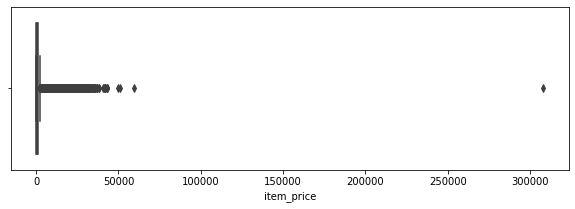

In [15]:
plt.figure(figsize=(10,3))
sns.boxplot(x='item_cnt_day', data=df_train)

plt.figure(figsize=(10,3))
sns.boxplot(x='item_price', data=df_train);

item_cnt_day 500이상, item_price 50,000 이상의 Outlier 제거

In [16]:
df_train = df_train[df_train.item_cnt_day < 500]
df_train = df_train[df_train.item_price < 50000]

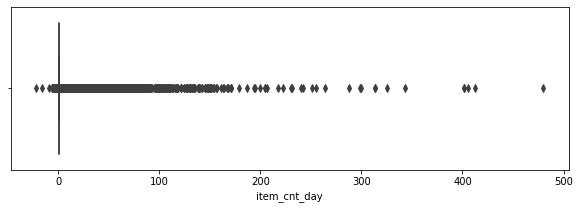

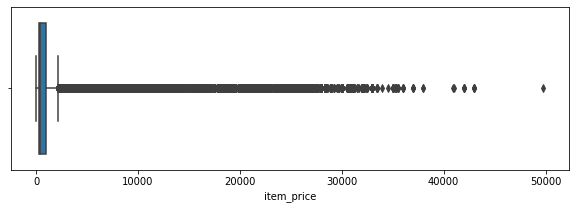

In [17]:
plt.figure(figsize=(10,3))
sns.boxplot(x='item_cnt_day', data=df_train)

plt.figure(figsize=(10,3))
sns.boxplot(x='item_price', data=df_train);

In [18]:
df_train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935826e+06,2.935826e+06,2.935826e+06,2.935826e+06,2.935826e+06
mean,1.456986e+01,3.300178e+01,1.019721e+04,8.907121e+02,1.239344e+00
std,9.422973e+00,1.622696e+01,6.324294e+03,1.719911e+03,1.923299e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,4.978200e+04,4.800000e+02


In [19]:
df_train = df_train[df_train.item_cnt_day >= 0]
df_train = df_train[df_train.item_price >= 0]

## Shops name 수정


In [21]:
df_shops.head(2)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1


In [23]:
df_shops.loc[df_shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'

In [24]:
 df_shops['city'] = df_shops['shop_name'].str.split(' ').map(lambda x: x[0])

In [25]:
df_shops.head(2)

,shop_name,shop_id,city
0,"!Якутск Орджоникидзе, 56 фран",0,!Якутск
1,"!Якутск ТЦ ""Центральный"" фран",1,!Якутск


In [26]:
df_shops.loc[df_shops.city == '!Якутск', 'city'] = 'Якутск'

수치 데이터가 아닌 문자 데이터는 데이터 분석이 번거롭다. 따라서 문자 데이터를 모두 수치 데이터로 Encoding하는 작업이 필요하다.

## df_shops Enconding


In [27]:
df_shops.city.value_counts()

Москва              13
Якутск               4
РостовНаДону         3
Воронеж              3
Тюмень               3
Новосибирск          2
Н.Новгород           2
Самара               2
Красноярск           2
Казань               2
Жуковский            2
Уфа                  2
СПб                  2
Томск                1
Сургут               1
СергиевПосад         1
Химки                1
Цифровой             1
Чехов                1
Мытищи               1
Омск                 1
Адыгея               1
Курск                1
Коломна              1
Калуга               1
Интернет-магазин     1
Выездная             1
Вологда              1
Волжский             1
Балашиха             1
Ярославль            1
Name: city, dtype: int64

In [28]:
city_encoder = LabelEncoder()
df_shops['city_code'] = city_encoder.fit_transform(df_shops['city'])
df_shops = df_shops[['shop_id', 'city_code']]
df_shops.head()

,shop_id,city_code
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2


## Item category Encoding

In [29]:
df_item_categories.head(2)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1


In [30]:
type_encoder = LabelEncoder()
df_item_categories['split_name'] = df_item_categories['item_category_name'].str.split(' - ')
df_item_categories['type'] = df_item_categories['split_name'].map(lambda x: x[0].strip())
df_item_categories['type_code'] = type_encoder.fit_transform(df_item_categories['type'])

In [31]:
df_item_categories.head(2)

,item_category_name,item_category_id,split_name,type,type_code
0,PC - Гарнитуры/Наушники,0,"[PC, Гарнитуры/Наушники]",PC,0
1,Аксессуары - PS2,1,"[Аксессуары, PS2]",Аксессуары,1


In [32]:
subtype_encoder = LabelEncoder()
df_item_categories['subtype'] = df_item_categories['split_name'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
df_item_categories['subtype_code'] = subtype_encoder.fit_transform(df_item_categories['subtype'])
df_item_categories = df_item_categories[['item_category_id', 'type_code', 'subtype_code']]

In [33]:
df_item_categories.head(2)

,item_category_id,type_code,subtype_code
0,0,0,31
1,1,1,11


## Item Encoding

이미 item_id와 item_category_id가 숫자로 매핑되어 있어 name만 drop해주면 됨



In [34]:
df_items.head(2)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76


In [35]:
df_items.drop(['item_name'], axis=1, inplace=True)
df_items.head(2)

,item_id,item_category_id
0,0,40
1,1,76


Encoding된 shops, category, item

In [36]:
df_shops.head(2)

,shop_id,city_code
0,0,29
1,1,29


In [37]:
df_item_categories.head(2)

,item_category_id,type_code,subtype_code
0,0,0,31
1,1,1,11


In [38]:
df_items.head(2)

,item_id,item_category_id
0,0,40
1,1,76


## df_test shop_id, item_id

In [39]:
df_test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [40]:
df_test.shop_id.value_counts()

5     5100
56    5100
53    5100
52    5100
47    5100
48    5100
57    5100
58    5100
59    5100
55    5100
36    5100
4     5100
37    5100
35    5100
38    5100
34    5100
46    5100
41    5100
44    5100
39    5100
49    5100
50    5100
42    5100
19    5100
6     5100
3     5100
2     5100
7     5100
10    5100
12    5100
28    5100
31    5100
26    5100
25    5100
22    5100
24    5100
21    5100
15    5100
16    5100
18    5100
14    5100
45    5100
Name: shop_id, dtype: int64

In [41]:
len(df_test.shop_id.unique())

42

총 42개의 shop_id가 있으며 각 shop_id마다 5,100개의 item이 있다.



In [42]:
len(set(df_test.item_id) - set(df_train.item_id))

363

df_test에는 있지만 df_train에는 없는 item_id가 총 363개 있다. 이는 df_train에 모든 종류의 item이 있지는 않다는 것을 뜻한다. 363개의 item에 대해서는 0개가 판매된 것으로 예측해야한다.

In [43]:
len(df_test) == 42*5100

True

42개의 shop_id, 5,100개의 item이 있으므로 df_test에는 총 42*5100 = 214,200개의 row가 있다

## 'date_block_num', 'shop_id', 'item_id'로 구성된 Matrix 만들기

In [44]:
num_date_block_num = len(df_train.date_block_num.value_counts())
num_date_block_num

34

In [45]:
matrix = []
cols = ['date_block_num', 'shop_id', 'item_id']
for i in range(34):
    sales = df_train[df_train.date_block_num == i]
    matrix.append(np.array(list(itertools.product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
# int8 -> Byte (-128 to 127), int16 -> Integer (-32768 to 32767)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols, inplace=True)

In [46]:
matrix.head()

,date_block_num,shop_id,item_id
139168,0,0,19
141406,0,0,27
144881,0,0,28
142572,0,0,29
138861,0,0,32


## df_train의 Groupby를 통한 Monthly Sales 구하기


df_train에 revenue를 추가한다

In [47]:
df_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
5,10.01.2013,0,25,2564,349.00,1.0


In [48]:
df_train['revenue'] = df_train['item_price'] * df_train['item_cnt_day']
df_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue
0,02.01.2013,0,59,22154,999.00,1.0,999.00
1,03.01.2013,0,25,2552,899.00,1.0,899.00
3,06.01.2013,0,25,2554,1709.05,1.0,1709.05
4,15.01.2013,0,25,2555,1099.00,1.0,1099.00
5,10.01.2013,0,25,2564,349.00,1.0,349.00


df_train의 Groupby

In [49]:
group = df_train.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day': ['sum']})
group.head()

item_cnt_day
                                        sum
date_block_num shop_id item_id             
0              0       32               6.0
                       33               3.0
                       35               1.0
                       43               1.0
                       51               2.0

In [50]:
group.columns = ['item_cnt_month']
group.head()

item_cnt_month
date_block_num shop_id item_id                
0              0       32                  6.0
                       33                  3.0
                       35                  1.0
                       43                  1.0
                       51                  2.0

In [52]:
group.reset_index(inplace=True)
group.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0


marix와 group을 merge한다



In [53]:
matrix.head()

,date_block_num,shop_id,item_id
139168,0,0,19
141406,0,0,27
144881,0,0,28
142572,0,0,29
138861,0,0,32


In [54]:
matrix = pd.merge(matrix, group, how='left')
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,19,NaN
1,0,0,27,NaN
2,0,0,28,NaN
3,0,0,29,NaN
4,0,0,32,6.0


In [55]:
matrix['item_cnt_month'] = (matrix['item_cnt_month'].fillna(0).clip(0, 30).astype(np.float16))
# NaN은 0으로 바꾸고, 범위를 0과 30사이로 정한다. 30이 넘어가는 수는 그다지 많지 않기 때문에 예측의 정확성을 위해 범위를 지정해준다. 타입도 float16으로 바꾼다.

In [56]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,19,0.0
1,0,0,27,0.0
2,0,0,28,0.0
3,0,0,29,0.0
4,0,0,32,6.0


이제 matrx에는 모든 date_block_num, shop_id, tiem_id에 따른 월별 판매량이 저장되어 있다.

## Matrix에 테스트 데이터 붙이기
